In [1]:
# !pip install boto3
# !pip install s3fs

In [2]:
import configparser
import boto3
import pandas as pd
import s3fs
config = configparser.ConfigParser()
config.read('aws.cfg')
aws_access_key = config['AWS']['aws_access_key']
aws_secret_key = config['AWS']['aws_secret_key']

In [3]:
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)

In [4]:
reviews = pd.read_csv('s3://techcatalyst-public/resources/sentiment/review.csv')
products = pd.read_csv('s3://techcatalyst-public/resources/sentiment/product.csv')

In [5]:
reviews.head()

,REVIEW ID,REVIEW TEXT
0,R1,"Great camera quality, but battery life could b..."
1,R2,Very satisfied with this smartphone. Worth eve...
2,R3,Excellent performance and battery life. Highly...
3,R4,Disappointed with the build quality. Feels cheap.
4,R5,Fantastic noise cancellation and sound quality.


In [6]:
products.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID
0,1,High-quality smartphone with excellent camera.,R1
1,1,High-quality smartphone with excellent camera.,R2
2,2,Durable laptop with long battery life.,R3
3,2,Durable laptop with long battery life.,R4
4,3,Wireless noise-canceling headphones.,R5


In [7]:
merged_df = products.merge(reviews, on='REVIEW ID', how='inner')

In [8]:
merged_df.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b..."
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.


In [9]:
comprehend = boto3.client(service_name='comprehend', region_name='us-west-2', aws_access_key_id= aws_access_key, aws_secret_access_key=aws_secret_key)

In [10]:
# create a function
def get_sentiment(mytxt):
     
    response = comprehend.detect_sentiment(
    Text= mytxt,
    LanguageCode='en')
     
    return response['Sentiment']

In [11]:
merged_df['Sentiment'] = merged_df['REVIEW TEXT'].apply(lambda x: get_sentiment(str(x)))

In [12]:
merged_df.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT,Sentiment
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b...",MIXED
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...,POSITIVE
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...,POSITIVE
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.,NEGATIVE
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.,POSITIVE


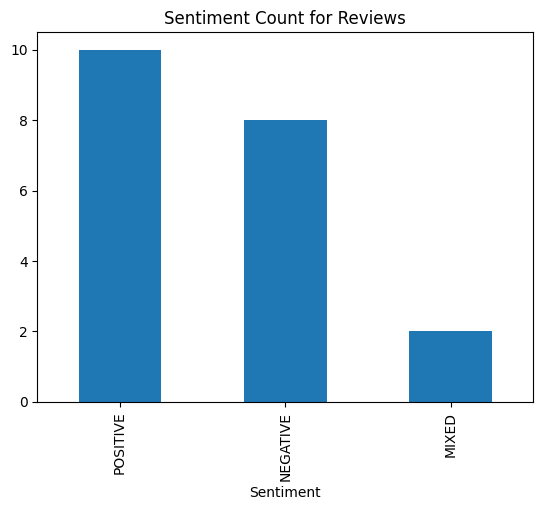

In [13]:
# Import Matplotlib
import matplotlib.pyplot as plt

# Generate and save a plot
ax = merged_df.Sentiment.value_counts().plot(kind='bar')
plt.title("Sentiment Count for Reviews")
plt.savefig('sentiment_analysis.jpg', format='jpg')


In [15]:
bucket_name = 'techcatalyst-public'

In [16]:

merged_df.to_csv(f"s3://{bucket_name}/peter/product_sentiment.csv", storage_options = {'key': aws_access_key, 'secret': aws_secret_key})
# s3.upload_file('sentiment_analysis.jpg', 'mybucket', 'image_0.jpg')

In [17]:
filename = 'sentiment_analysis.jpg'
key = 'peter/sentiment_analysis.jpg'
with open(filename, 'rb') as file_obj:
    s3.upload_fileobj(file_obj, bucket_name, key)

In [14]:
rekognition = boto3.client(service_name='rekognition', region_name='us-west-2', aws_access_key_id= aws_access_key, aws_secret_access_key=aws_secret_key)

In [19]:
states = pd.read_csv(f's3://{bucket_name}/resources/license-plates/states.csv')
states_list = states['0'].to_list()
states_list

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'OH',
 'Ohio',
 'OK',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'TN',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In [20]:
response = s3.list_objects_v2(Bucket=bucket_name, Prefix="resources/license-plates")
documents = [item['Key'] for item in response.get('Contents', [])]
documents.pop(0)
documents.pop(-1)

data = {}
for doc in documents:
    label = rekognition.detect_text(Image={'S3Object': {'Bucket': bucket_name, 'Name': doc}})
    var = ' '.join([item['DetectedText'] for item in label['TextDetections']])
    for state in states_list:
        if state.upper() in var.upper():
            data[doc] = state
data


{'resources/license-plates/license_plate10.jpeg': 'Arizona',
 'resources/license-plates/license_plate11.png': 'Texas',
 'resources/license-plates/license_plate12.jpeg': 'Texas',
 'resources/license-plates/license_plate13.jpeg': 'Alabama',
 'resources/license-plates/license_plate3.png': 'Massachusetts',
 'resources/license-plates/license_plate4.jpeg': 'Pennsylvania',
 'resources/license-plates/license_plate6.jpeg': 'California',
 'resources/license-plates/license_plate7.jpg': 'Nevada',
 'resources/license-plates/license_plate8.png': 'Ohio',
 'resources/license-plates/license_plate9.jpeg': 'Alabama'}

In [21]:
# states_info = pd.DataFrame(data=data, columns=['Image', 'State'])
# states_info.head()
images = list(data.keys())
states2 = list(data.values())
dataframe_data = {'Image': images, 'State': states2}
states_df = pd.DataFrame(dataframe_data)
states_df.head(10)

,Image,State
0,resources/license-plates/license_plate10.jpeg,Arizona
1,resources/license-plates/license_plate11.png,Texas
2,resources/license-plates/license_plate12.jpeg,Texas
3,resources/license-plates/license_plate13.jpeg,Alabama
4,resources/license-plates/license_plate3.png,Massachusetts
5,resources/license-plates/license_plate4.jpeg,Pennsylvania
6,resources/license-plates/license_plate6.jpeg,California
7,resources/license-plates/license_plate7.jpg,Nevada
8,resources/license-plates/license_plate8.png,Ohio
9,resources/license-plates/license_plate9.jpeg,Alabama


In [22]:
states_df.to_csv(f"s3://{bucket_name}/peter/image_state.csv", storage_options = {'key': aws_access_key, 'secret': aws_secret_key})

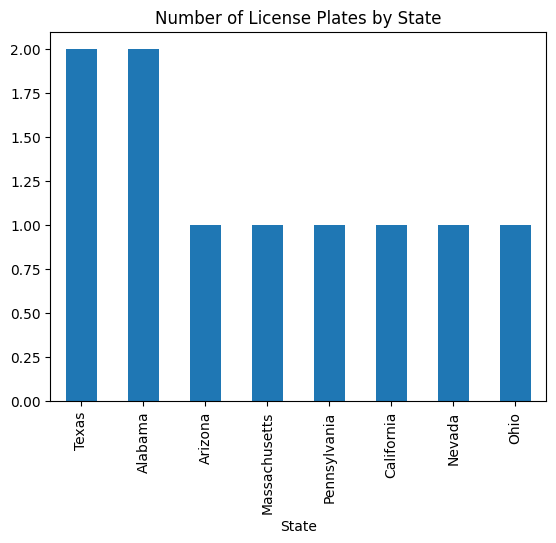

In [23]:
ax2 = states_df.State.value_counts().plot(kind='bar')
plt.title("Number of License Plates by State")
plt.savefig('license_plates_summary.jpg', format='jpg')

In [24]:
filename2 = 'license_plates_summary.jpg'
key2 = 'peter/license_plates_summary.jpg'
with open(filename2, 'rb') as file_obj:
    s3.upload_fileobj(file_obj, bucket_name, key2)